In [1]:
%matplotlib inline
import os
import seaborn as sns
import numpy as np
import numba

import matplotlib.pylab as plt
import matplotlib.cm as cm
from IPython.display import HTML

from tierpsy_features.velocities import get_velocity, get_relative_velocities, animate_velocity, \
_h_segment_position, _h_get_velocity

data = np.load('./data/worm_example.npz')

skeletons = data['skeleton']
dorsal_contour = data['dorsal_contour']
ventral_contour = data['ventral_contour']

contours = np.concatenate((dorsal_contour, ventral_contour[:, ::-1, :]), axis=1)
widths = data['widths']


save_dir = '/Users/ajaver/OneDrive - Imperial College London/paper_tierpsy_features/diagrams'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    

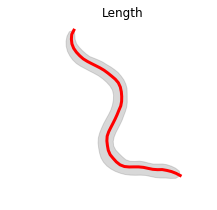

In [2]:
tt = 10

cc = contours[tt]
skel = skeletons[tt]


fig, ax = plt.subplots(figsize=(3,3))
plt.plot(skel[:, 0], skel[:, 1], 'r', lw=3)
plt.fill(cc[:, 0], cc[:, 1], color='gray', alpha=0.3)
plt.axis('equal')
plt.axis('off')

plt.title('Length')
plt.savefig(os.path.join(save_dir, 'length.pdf'), bbox_inches='tight')


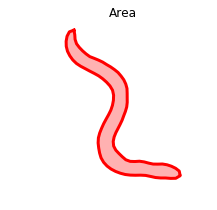

In [3]:
tt = 10

cc = contours[tt]
skel = skeletons[tt]

fig, ax = plt.subplots(figsize=(3,3))
plt.plot(cc[:, 0], cc[:, 1], 'r', lw=3)
plt.fill(cc[:, 0], cc[:, 1], color='r', alpha=0.3)
plt.axis('equal')
plt.axis('off')

plt.title('Area')

plt.savefig(os.path.join(save_dir, 'area.pdf'), bbox_inches='tight')


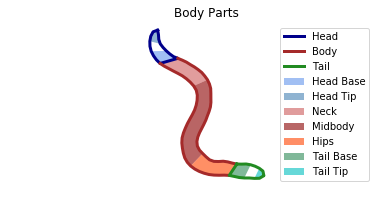

In [4]:
from tierpsy_features.helper import DataPartition

dp = DataPartition()

cnt_v = ventral_contour[tt]
cnt_d = dorsal_contour[tt]


def join_cnt(key):
    ini, fin = dp.partitions[key]
    
    d = cnt_d[ini:fin+1]
    v = cnt_v[ini:fin+1][::-1]
    if key == 'body':
        mm = np.array((np.nan, np.nan))[None, :]
        v = np.concatenate((v, mm))
        d = np.concatenate((d, mm))
        
    return np.concatenate((d, v, d[0][None, :]), axis=0)

part_k1 = ('head_base', 'head_tip', 'neck', 'midbody', 'hips', 'tail_base', 'tail_tip')
part_c1 = ('cornflowerblue', 'steelblue', 'indianred', 'darkred', 'orangered', 'seagreen', 'c')

fig, ax = plt.subplots(figsize=(6,3))
for k,c in zip(part_k1, part_c1):
    cc_p = join_cnt(k)
    plt.fill(cc_p[:, 0], cc_p[:, 1], c, alpha=0.6, label = k.replace('_', ' ').title())

part_k2 = ('head', 'body', 'tail')
part_c2 = ('darkblue', 'brown', 'forestgreen')

for k,c in zip(part_k2, part_c2):
    cc_p = join_cnt(k)
    plt.plot(cc_p[:, 0], cc_p[:, 1], c, lw=3, label = k.replace('_', ' ').title())
plt.axis('equal')
plt.axis('off')

plt.legend()
plt.title('Body Parts')

plt.savefig(os.path.join(save_dir, 'body_parts.pdf'), bbox_inches='tight')


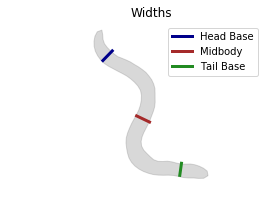

In [5]:
from tierpsy_features.postures import get_widths

segment_widths = get_widths(widths)

tt = 10

cc = contours[tt]
skel = skeletons[tt]
W = widths[tt]


fig, ax = plt.subplots(figsize=(4,3))
plt.fill(cc[:, 0], cc[:, 1], color='gray', alpha=0.3)

part_k = ('head_base', 'midbody', 'tail_base')
part_c = ('darkblue', 'brown', 'forestgreen')

for k, c in zip(part_k, part_c):

    ind = int(np.round(np.mean(dp.partitions[k])))
    assert ind > 0 and ind < skel.shape[0] -1

    ss = skel[ind]
    dR = skel[ind + 1] - skel[ind - 1]
    #perpendicular slop
    ang = np.arctan2(dR[1], dR[0]) + np.pi/2

    w = W[ind]
    dx =w*np.cos(ang)/2
    dy =w*np.sin(ang)/2

    xx = (ss[0] - dx, ss[0] + dx)
    yy = (ss[1] - dy, ss[1] + dy)
    plt.plot(xx, yy, c, lw=3, label = k.replace('_', ' ').title())
    
plt.axis('equal')
plt.axis('off')
plt.legend()

plt.title('Widths')
plt.savefig(os.path.join(save_dir, 'widths.pdf'), bbox_inches='tight')


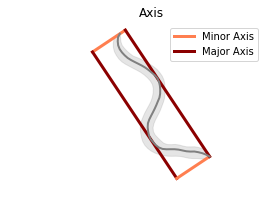

In [6]:
import cv2


cc = contours[tt]
skel = skeletons[tt]

rect = cv2.minAreaRect(skel.astype(np.float32))
box = cv2.boxPoints(rect)


fig, ax = plt.subplots(figsize=(4,3))
cols = ['coral', 'darkred']
hh = []
for ini, c in enumerate(cols + cols):
    fin = ini+1 if ini <3 else 0
    
    xx,yy = zip(box[ini], box[fin])
    
    h, = plt.plot(xx, yy, c, lw=3)
    hh.append(h)
    
plt.plot(skel[:, 0], skel[:, 1], 'gray', lw=2)
plt.fill(cc[:, 0], cc[:, 1], color='gray', alpha=0.2)

plt.axis('equal')
plt.axis('off')
plt.legend(hh[:2], ['Minor Axis', 'Major Axis'])
plt.title('Axis')

plt.savefig(os.path.join(save_dir, 'axis.pdf'), bbox_inches='tight')


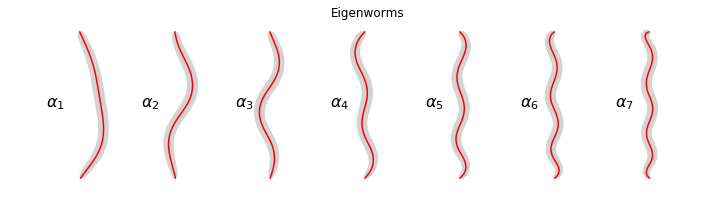

In [7]:
import tables
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from tierpsy_features.postures import load_eigen_projections, _angles

eigen_worms = load_eigen_projections()

W = np.nanmedian(widths, axis=0)/2
R = np.sqrt(np.sum(np.diff(skeletons, axis = 1)**2, axis=2))
seg_size = np.nanmedian(np.sum(R, axis=1))/48


angs = 2.5*eigen_worms #increate the value of the eigenworms more obvious for visualizatin purposes

ske_x = np.sin(angs)*seg_size
ske_x = np.pad(ske_x, ((0,0), (1, 0)), 'constant', constant_values = 0)
ske_x = np.cumsum(ske_x, axis=1)

ske_y = np.cos(angs)*seg_size
ske_y = np.pad(ske_y, ((0,0), (1, 0)), 'constant', constant_values = 0)
ske_y = np.cumsum(ske_y, axis=1)

fig, ax = plt.subplots(figsize = (12,3))
for ii, (xx, yy) in enumerate(zip(ske_x, ske_y)):
    
    patches = []
    
    
    offset = ii*600
    xx = xx  + offset
    
    plt.text(-220 + offset, 450, r'$\alpha_{}$'.format(ii+1), fontsize = 16)
    
    
    for x, y, w in zip(xx, yy, W):
        c = Circle((x,y), w)
        patches.append(c)
        
    p = PatchCollection(patches, color='lightgrey')
    ax.add_collection(p)
    
    plt.plot(xx, yy, 'r')
    
    plt.axis('equal')
    plt.axis('off')
    
    plt.title('Eigenworms')
    plt.savefig(os.path.join(save_dir, 'eigenprojections.pdf'), bbox_inches='tight')


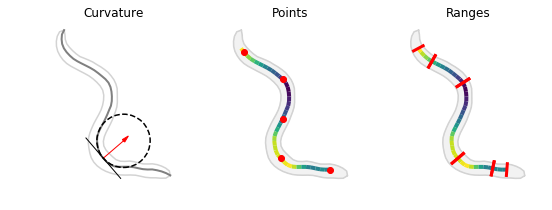

In [8]:
from matplotlib.collections import LineCollection

from tierpsy_features.curvatures import curvature_grad

cnt = contours[tt]
skel = skeletons[tt]
W = np.nanmedian(widths, axis=0)

curvatures = curvature_grad(skeletons)
curv = curvatures[tt]
curv_range = (np.nanmin(curv), np.nanmax(curv))
curv_n = (curv - curv_range[0])/(curv_range[1] - curv_range[0])


good = ~np.isnan(curv_n)
ss = skel[good].T
points = np.array(ss).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)


segments_ind_dflt = {
            'head' : 5/48,
            'neck' : 15/48,
            'midbody' : 24/48, 
            'hips' : 33/48,
            'tail' : 44/48,
        }

max_angle_index = curvatures.shape[-1]-1
segments_ind = {k:int(round(x*max_angle_index)) for k,x in segments_ind_dflt.items()}


def plot_curvature(ax):
    ax.plot(cnt[:, 0], cnt[:, 1], color='lightgray')
    ax.fill(cnt[:, 0], cnt[:, 1], color='gray', alpha=0.1)
    lc = LineCollection(segments, array = curv[good], cmap='viridis', lw=4)
    ax.add_collection(lc)
    ax.axis('equal')
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize = (9,3))

plot_curvature(axs[1])
for k in segments_ind_dflt.keys():
    ii = segments_ind[k]
    axs[1].plot(skel[ii, 0], skel[ii, 1], 'or')
    axs[1].set_title('Points')

ini_c, fin_c = np.where(good)[0][[0, -1]]

plot_curvature(axs[2])
for k in ('head', 'neck', 'midbody', 'hips', 'tail'):

    for ind in dp.partitions[k]:
        ind = max(ini_c, ind)
        ind = min(fin_c, ind)


        ss = skel[ind]
        dR = skel[ind + 1] - skel[ind - 1]
        #perpendicular slop
        ang = np.arctan2(dR[1], dR[0]) + np.pi/2

        w = W[ind]
        dx =w*np.cos(ang)/2
        dy =w*np.sin(ang)/2

        xx = (ss[0] - dx, ss[0] + dx)
        yy = (ss[1] - dy, ss[1] + dy)
        axs[2].plot(xx, yy, 'r', lw=3, label = k)
    axs[2].set_title('Ranges')
    

axs[0].plot(cnt[:, 0], cnt[:, 1], color='lightgray')
axs[0].plot(skel[:, 0], skel[:, 1], lw = 2, color='gray')
ind = segments_ind['hips']
ss = skel[ind]
dR = skel[ind + 1] - skel[ind - 1]

ang_t = np.arctan2(dR[1], dR[0])
#perpendicular slop
ang_p = ang_t + np.pi/2

Rw = 1/curv[ind]

dx = Rw*np.cos(ang_p)
dy = Rw*np.sin(ang_p)
xp = (ss[0], ss[0] + dx)
yp = (ss[1], ss[1] + dy)
axs[0].plot(xp, yp, 'r', lw=1, label = k)

dx = Rw*np.cos(ang_t)
dy = Rw*np.sin(ang_t)
xt = (ss[0] - dx, ss[0] + dx)
yt = (ss[1] - dy, ss[1] + dy)

axs[0].plot(xt, yt, 'k', lw=1)
axs[0].arrow(xp[1]-1, yp[1]-1, 1, 1, head_width=15, head_length=30, fc='r', ec='r')

circle = Circle((xp[1], yp[1]), Rw, fill=False, edgecolor="k", linewidth=1.5, linestyle='--')
circle.set_zorder(20)

axs[0].add_patch(circle)
axs[0].axis('equal')
axs[0].axis('off')
axs[0].set_title('Curvature')
plt.savefig(os.path.join(save_dir, 'curvatures.pdf'), bbox_inches='tight')


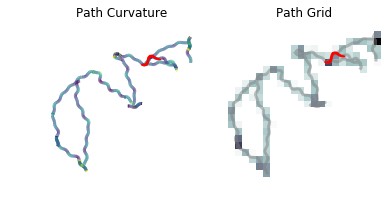

In [9]:
import numba
from tierpsy_features import get_path_curvatures


tc = 800
cnt = contours[tc]
skel = skeletons[tc]

path_curvatures_df, path_coords_df = get_path_curvatures(skeletons)
bin_size_microns = 250
max_tt = 5000

body_part = 'midbody'
col_x = 'coord_x_' + body_part
col_y = 'coord_y_' + body_part

path_x = path_coords_df[col_x].values[:max_tt]
path_y = path_coords_df[col_y].values[:max_tt]

path_curvature = path_curvatures_df['path_curvature_' + body_part].values[:max_tt]

def digitize(coord):
    
    coord_n = ((coord - np.nanmin(coord))/bin_size_microns).round()
    
    coord_n = coord_n[~np.isnan(coord_n)]
    coord_n = coord_n.astype(np.int)
    return coord_n



def calc_histograms(x_digit, y_digit):
    n_x = np.max(x_digit) + 1
    n_y = np.max(y_digit) + 1
    
    H = np.zeros((n_y, n_x))
    for ii in range(y_digit.size):
        x = x_digit[ii]
        y = y_digit[ii]
        
        H[y, x] += 1
        
    return H

x_digit = digitize(path_x)
y_digit = digitize(path_y)

H = calc_histograms(x_digit, y_digit)

fig, axs = plt.subplots(1, 2, figsize = (6, 3))


axs[1].imshow(H, cmap = 'bone_r')#'PuBuGn')#'YlOrBr')
axs[1].invert_yaxis()


c_mx = np.nanmin(path_x)
xx = (path_x - c_mx)/bin_size_microns

c_my = np.nanmin(path_y)
yy = (path_y - c_my)/bin_size_microns
axs[1].plot(xx, yy, 'gray', lw = 3, alpha=0.5)


xx = (cnt[:, 0] - c_mx)/bin_size_microns
yy = (cnt[:, 1] - c_my)/bin_size_microns

ff, = axs[1].fill(xx, yy, color='r')
ff.set_zorder(20)

axs[1].axis('equal')
axs[1].axis('off')
axs[1].set_title('Path Grid')

curv_range = np.nanpercentile(path_curvature, (5, 95))
body_coords = np.stack((path_x, path_y)).T
points = body_coords.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, 
                    cmap = plt.get_cmap('viridis'),
                    norm = plt.Normalize(*curv_range))
lc.set_array(path_curvature)
lc.set_linewidth(3)

ff, = axs[0].fill(cnt[:, 0], cnt[:, 1], color='r')
ff.set_zorder(20)

axs[0].add_collection(lc)
axs[0].axis('equal')
axs[0].axis('off')
axs[0].set_title('Path Curvature')

plt.savefig(os.path.join(save_dir, 'path.pdf'), bbox_inches='tight')


/Users/ajaver/Documents/GitHub/tierpsy-features/tierpsy_features/helper.py:148: RuntimeWarning: Mean of empty slice
  d_transform = func(sub_data, axis=segment_axis)


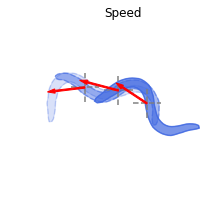

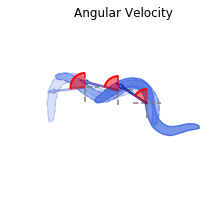

In [43]:
from matplotlib import patches
from tierpsy_features.velocities import get_velocity, get_relative_velocities, animate_velocity, \
_h_segment_position, _h_get_velocity

d_r = (0, skeletons.shape[0])
ini_t = d_r[0]
fin_t = d_r[1]

coords, orientation_v = _h_segment_position(skeletons, partition = 'body')

for ini_t in [815]:#range(0, 1000, 50):
    delT = 25
    
    cols = ('royalblue', 'royalblue', 'royalblue')
    #cols = ('lightsalmon', 'tomato', 'firebrick')
    marks = ('--', '--', '-')
    
    
    for s_type in ['Speed', 'Angular Velocity']:
        fig=plt.figure(figsize=(3,3))
        ax=fig.add_subplot(1,1,1)
        for ii, t in enumerate([ini_t, ini_t + delT, ini_t + delT*2]):
            c = cols[ii]
            m = marks[ii]
            skel = contours[t]
            aa = 0.2 + 0.25*ii

            plt.fill(skel[:, 0], skel[:, 1], m, color = c, alpha= aa)
            plt.plot(skel[:, 0], skel[:, 1], m, color = c, alpha= aa)
            #plt.plot(coords[t, 0], coords[t, 1], 'o', color = c)

            arrow_size = orientation_v[t]/2
            ini_arrow = coords[t]
            
            
            
            off_l = 100
            x_c = (coords[t, 0] - off_l,coords[t, 0]+off_l)
            y_c = (coords[t, 1] - off_l,coords[t, 1]+off_l)
            
            plt.plot([coords[t, 0]]*2, y_c, '--', color = 'gray')
            plt.plot(x_c, [coords[t, 1]]*2, '--', color = 'gray')

            
            if s_type != 'Speed':
                orient_arrow = patches.Arrow(*ini_arrow, *arrow_size,  width=50, fc= c, ec='darkblue', alpha= aa + 0.1)
            
                ang_ = np.arctan2(arrow_size[1], arrow_size[0])*180/np.pi
                
                
                r = 100
                arc_ = patches.Arc(coords[t], 
                                   height=r*2,
                                   width=r*2,
                                   angle=0, 
                                   theta1 = 90, 
                                   theta2 = ang_, 
                                   color='r', 
                                   lw=2
                                  )
                arc_.set_zorder(25)
                ax.add_patch(arc_)
                
                w_ = patches.Wedge(coords[t], r, 90, ang_, alpha=0.5, color='r')
                w_.set_zorder(24)
                ax.add_patch(w_)
                
            else:
                orient_arrow = patches.Arrow(*ini_arrow, *arrow_size,  width=50, fc= 'red', ec='red', alpha= 1)
                
                
                
                
                
            orient_arrow.set_zorder(20 - ii)
            ax.add_patch(orient_arrow)

            
            
            
        plt.title(t)
        plt.axis('equal')

        plt.axis('equal')
        plt.axis('off')
        plt.title(s_type)

        plt.savefig(os.path.join(save_dir, s_type + '.pdf'), bbox_inches='tight')



/Users/ajaver/Documents/GitHub/tierpsy-features/tierpsy_features/helper.py:148: RuntimeWarning: Mean of empty slice
  d_transform = func(sub_data, axis=segment_axis)


[-256.05410271   77.24452995]


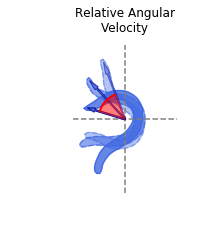

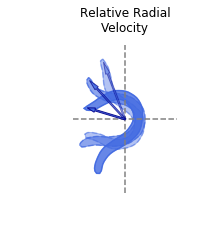

In [60]:
from tierpsy_features.velocities import _h_segment_position, _h_center_skeleton, nanunwrap

d_r = (3500, 5500)
ini_t = d_r[0]
fin_t = d_r[1]

partition = 'head_tip'
base_partition = 'body'

delta_frames = 8
fps = 25

coords, orientation_v = _h_segment_position(skeletons, partition = base_partition)
orientation = np.arctan2(orientation_v[:, 0], orientation_v[:, 1])
#wrap the angles so the change is continous no jump between np.pi and -np.pi
orientation = nanunwrap(orientation) 

cnt_centred = _h_center_skeleton(contours, orientation, coords)
skel_centred = _h_center_skeleton(skeletons, orientation, coords)

r_rad, r_angular = get_relative_velocities(skel_centred, [partition], delta_frames, fps)
segment_coords, _ = _h_segment_position(skel_centred, partition = partition)

arrow_size = segment_coords[t]
ini_arrow = (0, 0)

for ini_t in [380]:#range(375, 500, 25):#[200]:#
    delT = 10
    
    
    #cols = ('lightsalmon', 'tomato', 'firebrick')[::-1]
    cols = ('royalblue', 'royalblue', 'royalblue')
    marks = ('--', '--', '-')[::-1]
    
    for s_type in ['angular', 'radial']:
        fig=plt.figure(figsize=(3,3))
        ax=fig.add_subplot(1,1,1)
        for ii, t in enumerate([ini_t, ini_t + delT, ini_t + delT*2]):

            c = cols[ii]
            m = marks[ii]

            skel = cnt_centred[t]
            #skel = contours[t] - coords[t]

            aa = 0.8 - 0.2*ii
            plt.fill(skel[:, 0], skel[:, 1], m, color = c, alpha= aa)
            plt.plot(skel[:, 0], skel[:, 1], m, color = c, alpha= aa)
            #plt.plot(coords[t, 0], coords[t, 1], 'o', color = c)

            #skel_a = skels_c[ini_t:fin_t]
            arrow_size = segment_coords[t]
            ini_arrow = np.zeros_like(arrow_size)

            orient_arrow = patches.Arrow(*ini_arrow, *arrow_size,  width=50, fc= c, ec='darkblue', alpha= aa + 0.1)
            orient_arrow.set_zorder(20 - ii)
            ax.add_patch(orient_arrow)


        plt.plot((0,0), (-500, 500), '--', color = 'gray')
        plt.plot((-350, 350), (0,0), '--', color = 'gray')
        #ll, = plt.plot(0, 0, 'ok', markersize = 8)
        #ll.set_zorder(21)

        if s_type == 'angular':
            r = 180
            print(segment_coords[ini_t])
            ang2_ = np.arctan2(*segment_coords[ini_t][::-1])*180/np.pi
            ang1_ = np.arctan2(*segment_coords[ini_t + delT*2][::-1])*180/np.pi
            arc_ = patches.Arc((0, 0), 
                               height=r*2,
                               width=r*2,
                               angle=0, 
                               theta1 = ang1_, 
                               theta2 = ang2_, 
                               color='r', 
                               lw=2
                              )
            arc_.set_zorder(25)
            ax.add_patch(arc_)

            w_ = patches.Wedge((0, 0), r, ang1_, ang2_, alpha=0.5, color='r')
            w_.set_zorder(24)
            ax.add_patch(w_)
        
        
        plt.axis('equal')
        plt.axis('off')
        plt.title('Relative {}\nVelocity'.format(s_type.title()))
    
        plt.savefig(os.path.join(save_dir, 'relative_velocity_{}.pdf'.format(s_type)), bbox_inches='tight')


/Users/ajaver/Documents/GitHub/tierpsy-features/tierpsy_features/helper.py:148: RuntimeWarning: Mean of empty slice
  d_transform = func(sub_data, axis=segment_axis)


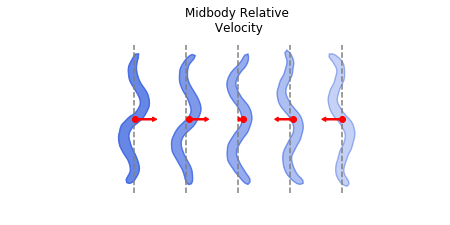

In [61]:


d_r = (3500, 5500)
ini_t = d_r[0]
fin_t = d_r[1]

partition = 'midbody'
base_partition = 'body'


delta_frames = 8
fps = 25

coords, orientation_v = _h_segment_position(skeletons, partition = base_partition)
orientation = np.arctan2(orientation_v[:, 0], orientation_v[:, 1])
#wrap the angles so the change is continous no jump between np.pi and -np.pi
orientation = nanunwrap(orientation) 

cnt_centred = _h_center_skeleton(contours, orientation, coords)
skel_centred = _h_center_skeleton(skeletons, orientation, coords)


p_obj = DataPartition(['midbody'], n_segments = skel_centred.shape[1])
segment_coords = p_obj.apply(skel_centred, 'midbody', func=np.nanmean)

midbody_velocity = _h_get_velocity(segment_coords[:, 0], delta_frames, fps)


for ini_t in [525]:#range(375, 500, 25):#[200]:#
    delT = 8
    
    tot_frames = 5
    cols = ['royalblue']*tot_frames#['firebrick']*tot_frames
    marks = ['-']*tot_frames
    
    
    fig, ax = plt.subplots(figsize=(7,3))
    
    alpha_sc = np.linspace(0.3, 0.8, tot_frames)[::-1]
    for ii in range(tot_frames):
        
        t = ini_t + delT*ii
        offset = ii*350
        
        c = cols[ii]
        m = marks[ii]
        
        skel = cnt_centred[t]
        #skel = contours[t] - coords[t]
        
        plt.fill(skel[:, 0] + offset, skel[:, 1], m, color = c, alpha = alpha_sc[ii])
        plt.plot(skel[:, 0] + offset, skel[:, 1], m, color = c, alpha = alpha_sc[ii])
        
        
        #skel_a = skels_c[ini_t:fin_t]
        
        
        arrow_size = (midbody_velocity[t]*2.5, 0)
        ini_arrow = (offset + segment_coords[t, 0], 0)
        plt.plot((offset, offset), (-500, 500), '--', color='gray')
        plt.plot(*ini_arrow, 'ro')
        
        orient_arrow = patches.Arrow(*ini_arrow, *arrow_size,  width=50, fc= 'red', ec='red', alpha= 1)
        orient_arrow.set_zorder(20 - ii)
        ax.add_patch(orient_arrow)
        
    plt.title(t)
    plt.axis('equal')
    plt.axis('off')
    plt.title('Midbody Relative\n Velocity')

plt.savefig(os.path.join(save_dir, 'midbody_relative_velocity.pdf'), bbox_inches='tight')


In [26]:
a3 = patches.FancyArrowPatch((-0.4,-0.6), (0.4,-0.6),connectionstyle="arc3,rad=.5")
                             